In [1]:
import os 
import sys
import random 
import numpy as np
from locscale.include.emmer.ndimage.map_utils import extract_window, load_map, get_all_voxels_inside_mask
from locscale.include.emmer.ndimage.profile_tools import frequency_array 
from locscale.include.emmer.ndimage.fsc_util import calculate_phase_correlation_maps 
from locscale.emmernet.emmernet_functions import standardize_map
from tqdm import tqdm

In [2]:
#
emmap_path_1 = "/home/abharadwaj1/papers/elife_paper/figure_information/inputs/sub_tomogram_analysis/emd_13234/EMD_13234_unsharpened_fullmap.mrc"
emmap_path_2 = "/home/abharadwaj1/papers/elife_paper/figure_information/inputs/sub_tomogram_analysis/emd_13234/deepemhancer/emd_13234_deepemhancer_wide.mrc"
mask_path = "/home/abharadwaj1/papers/elife_paper/figure_information/inputs/sub_tomogram_analysis/emd_13234/EMD_13234_unsharpened_fullmap_confidenceMap_custom_loc_5A.mrc"
output_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/phase_correlations/emd_13234/deepemhancer/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
emmap_1, apix = load_map(emmap_path_1)
emmap_2, apix = load_map(emmap_path_2)
mask, apix = load_map(mask_path)

mask_binarized = (mask > 0.99).astype(np.int_)


print("emmap 1 mean: ", np.mean(emmap_1))
print("emmap 2 mean: ", np.mean(emmap_2))
print("emmap 1 std: ", np.std(emmap_1))
print("emmap 2 std: ", np.std(emmap_2))

all_voxels = get_all_voxels_inside_mask(mask, mask_threshold=0.99)
# remove edge voxels
edge_buffer = 40
all_voxels = [voxel for voxel in all_voxels if voxel[0] > edge_buffer and voxel[0] < mask.shape[0] - edge_buffer and voxel[1] > edge_buffer and voxel[1] < mask.shape[1] - edge_buffer and voxel[2] > edge_buffer and voxel[2] < mask.shape[2] - edge_buffer]

sampled_voxels = random.sample(all_voxels, 1000)

window_size_pix = int(round(80/apix))

phase_correlations = []
for center in tqdm(sampled_voxels):
    window_emmap_1 = extract_window(emmap_1, center, window_size_pix)
    window_emmap_2 = extract_window(emmap_2, center, window_size_pix)

    phase_correlation = calculate_phase_correlation_maps(window_emmap_1, window_emmap_2)
    phase_correlations.append(phase_correlation)


emmap 1 mean:  2.4317253e-05
emmap 2 mean:  0.002543723
emmap 1 std:  0.00043999782
emmap 2 std:  0.037571736


100%|██████████| 1000/1000 [00:34<00:00, 29.34it/s]


In [3]:
def pretty_plot_series(x_array,list_of_y_array, figsize_cm=(14,8), fontsize=10,linewidth=1, \
                                font="Helvetica",fontscale=1, alpha=0.2, xticks=None, num_xticks=5, yticks=None, ylims=None, xlims=None, labelsize=None, title=None):
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    from locscale.include.emmer.ndimage.profile_tools import crop_profile_between_frequency
    import seaborn as sns
    import matplotlib 
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    # set the global font size for the plot

        
    plt.rcParams.update({'font.size': fontsize})
    figsize = (figsize_cm[0]/2.54, figsize_cm[1]/2.54) # convert cm to inches
    
    fig, ax1 = plt.subplots(figsize=figsize, dpi=600)  # DPI is fixed to 600 for publication quality
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    # Set font size for all text in the figure
    sns.set_style("white")

    """
    Plots a series of y arrays with a common x array. 
    """
    mean_y = np.mean(list_of_y_array, axis=0)
    std_y = np.std(list_of_y_array, axis=0)
    extreme_y_min = mean_y - std_y
    extreme_y_max = mean_y + std_y

    if len(list_of_y_array) > 1:
        ax1.plot(x_array, mean_y, color='black', linewidth=linewidth)
        ax1.fill_between(x_array, extreme_y_min, extreme_y_max, color='grey', alpha=alpha)
    else:
        ax1.plot(x_array, list_of_y_array[0], color='black', linewidth=linewidth)

    if xticks is not None:
        ax1.set_xticks([round(xtick,2) for xtick in xticks])
    else:
        ax1.set_xticks(np.linspace(x_array[0], x_array[-1], num_xticks).round(2))
    if yticks is not None:
        ax1.set_yticks(yticks)
    if ylims is not None:
        ax1.set_ylim(ylims)
    if xlims is not None:
        ax1.set_xlim(xlims)
    if labelsize is not None:
        ax1.tick_params(axis='both', which='major', labelsize=labelsize)

    ax1.set_xlabel(r'Spatial frequency ($\AA^{-1}$)')
    ax1.set_ylabel('Phase correlation')

    # Obtain a second X axis with the resolution in Angstroms
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xticklabels(np.round(1/ax1.get_xticks(), 1))
    ax2.set_xlabel(r'Resolution ($\AA$)')

    if title is not None:
        ax1.set_title(title)

    plt.tight_layout()

    return fig
        

In [4]:
print([len(x) for x in phase_correlations if len(x) != 22])


[]


/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


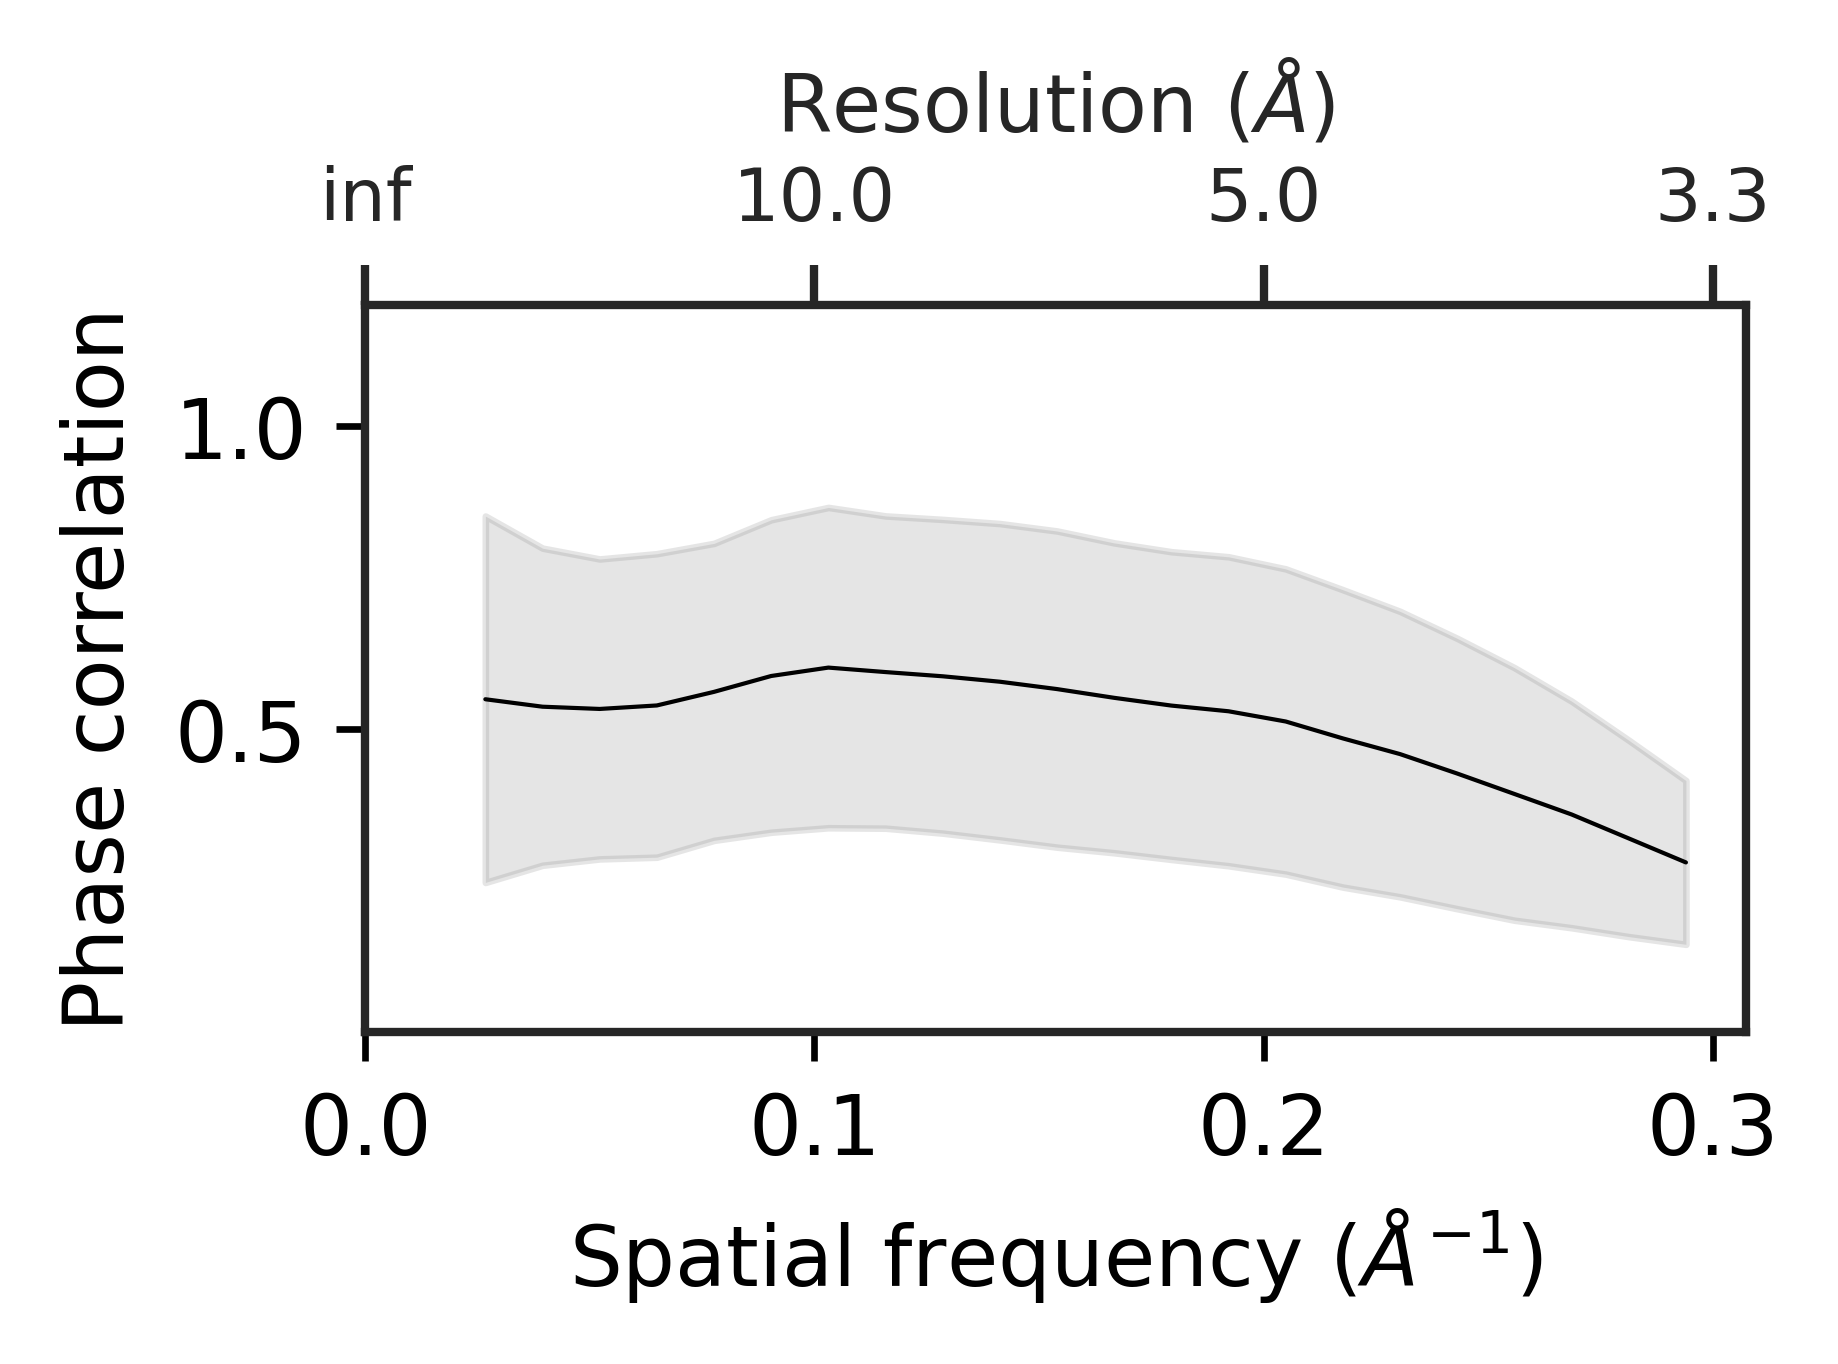

In [5]:
ylims = [0, 1.2]
yticks = [0.5, 1]
xticks = [0, 0.1, 0.2, 0.3]
freq_local = frequency_array(phase_correlations[0], apix)
fig_local = pretty_plot_series(freq_local, phase_correlations, figsize_cm=(8,6), fontsize=10,linewidth=0.5, \
                                font="Helvetica",fontscale=1, alpha=0.2, xticks=xticks, num_xticks=5, yticks=yticks, ylims=ylims, xlims=None, labelsize=None, title=None)

In [6]:
global_phase_correlation = calculate_phase_correlation_maps(emmap_1, emmap_2)
freq_global = frequency_array(global_phase_correlation, apix)
resolutions_global = np.round(1/freq_global, 1)
# five equally spaced ticks
ticks_global = np.linspace(0, len(freq_global)-1, 6).astype(np.int_)
freq_ticks_global = freq_global[ticks_global]



/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


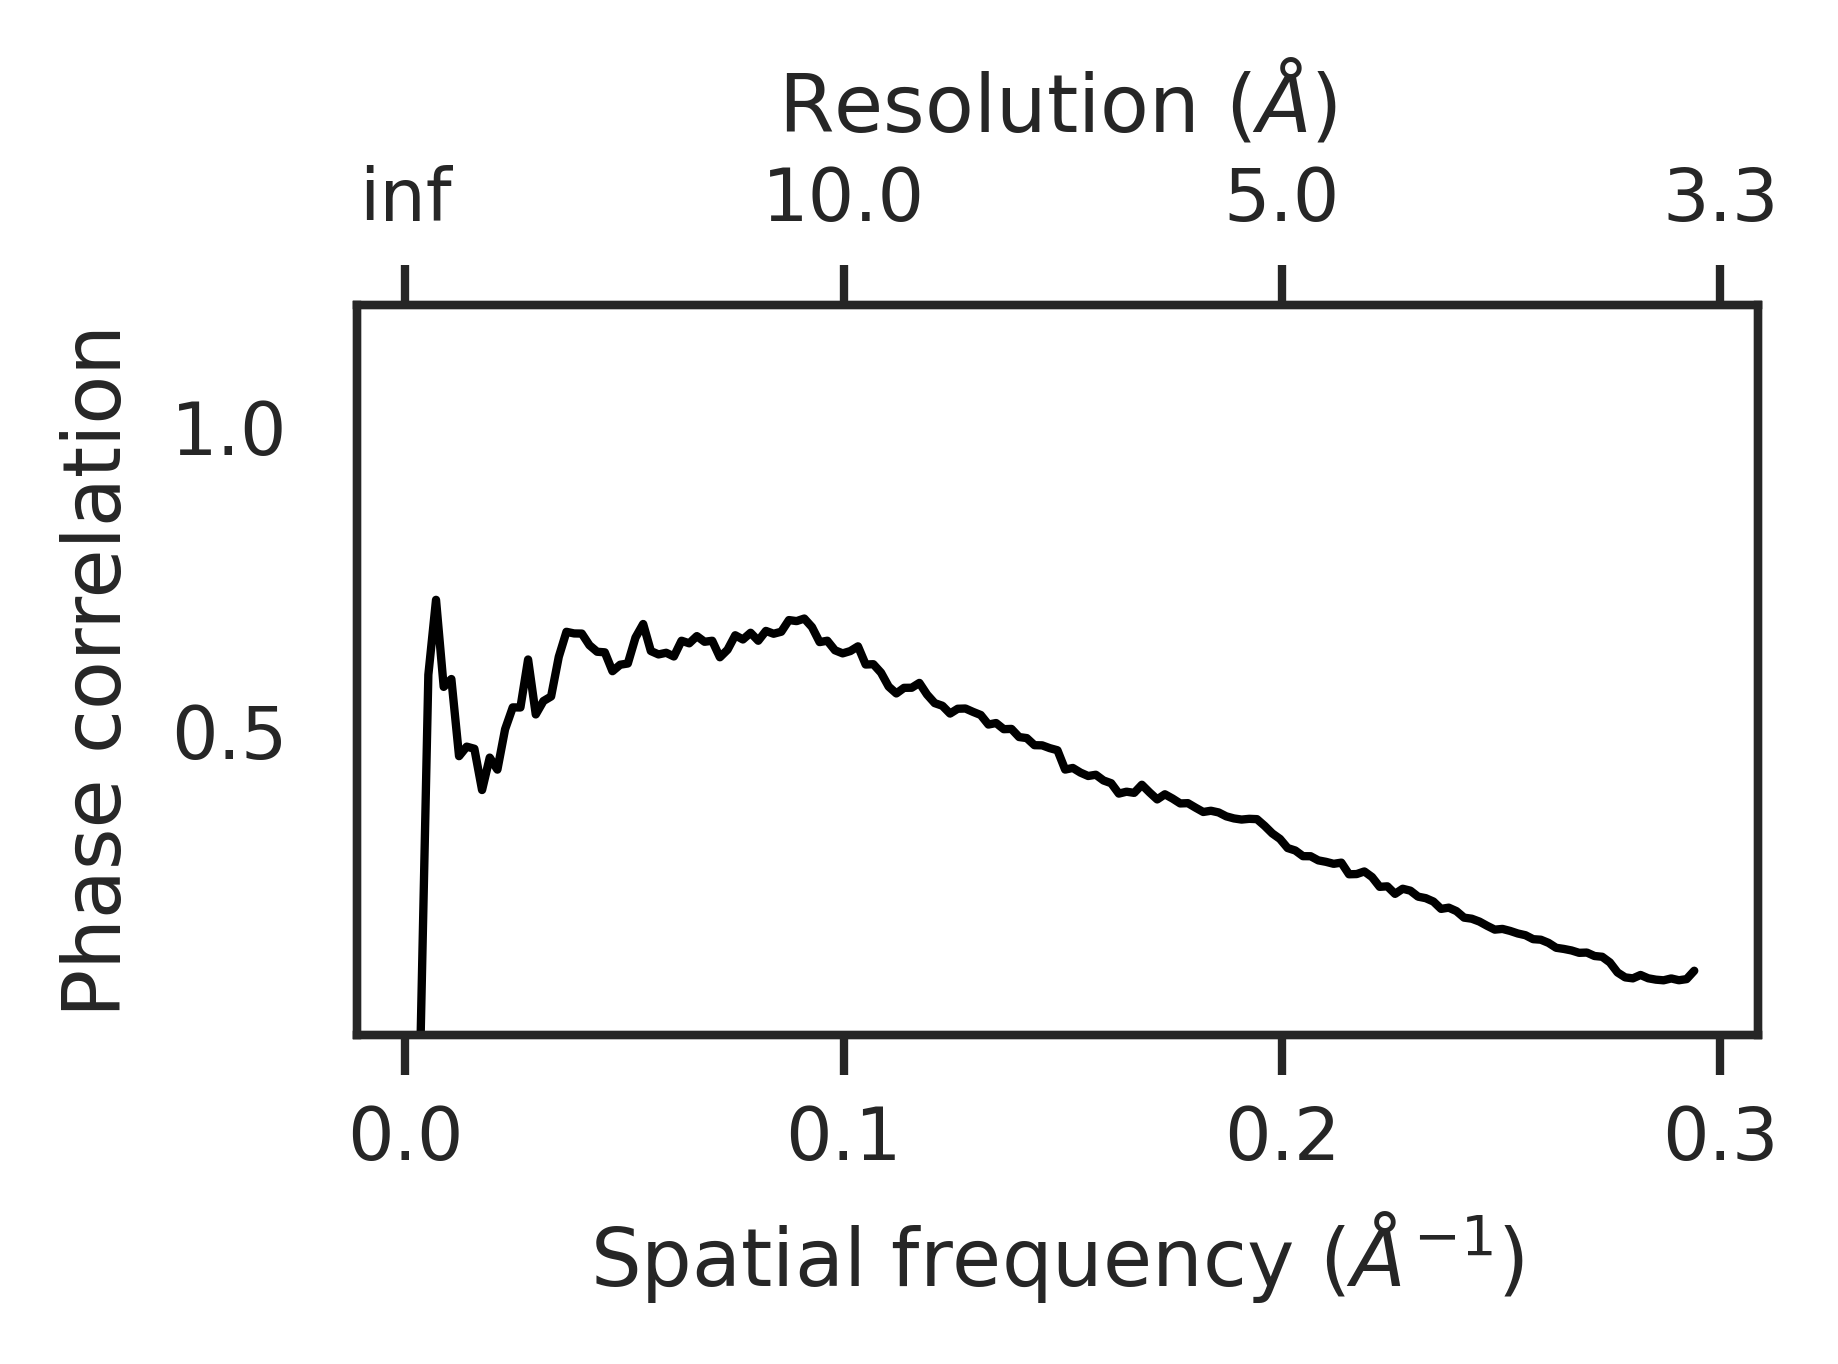

In [7]:
fig_phase_corr_global = pretty_plot_series(freq_global, [global_phase_correlation], figsize_cm=(8,6), fontsize=10,linewidth=1,\
                                font="Helvetica",fontscale=1, alpha=0.3, xticks=xticks, num_xticks=5, yticks=yticks, \
                                ylims=ylims, xlims=None, labelsize=None, title=None)



In [8]:
fig_local_path = os.path.join(output_folder, "phase_correlation_local.pdf")
fig_local.savefig(fig_local_path, bbox_inches='tight')

fig_global_path = os.path.join(output_folder, "phase_correlation_global.pdf")
fig_phase_corr_global.savefig(fig_global_path, bbox_inches='tight')



In [9]:
window_size_pix_20 = int(round(20/apix))

phase_correlations_20 = []
for center in tqdm(sampled_voxels):
    window_emmap_1 = extract_window(emmap_1, center, window_size_pix_20)
    window_emmap_2 = extract_window(emmap_2, center, window_size_pix_20)

    phase_correlation = calculate_phase_correlation_maps(window_emmap_1, window_emmap_2)
    phase_correlations_20.append(phase_correlation)

100%|██████████| 1000/1000 [00:01<00:00, 760.23it/s]


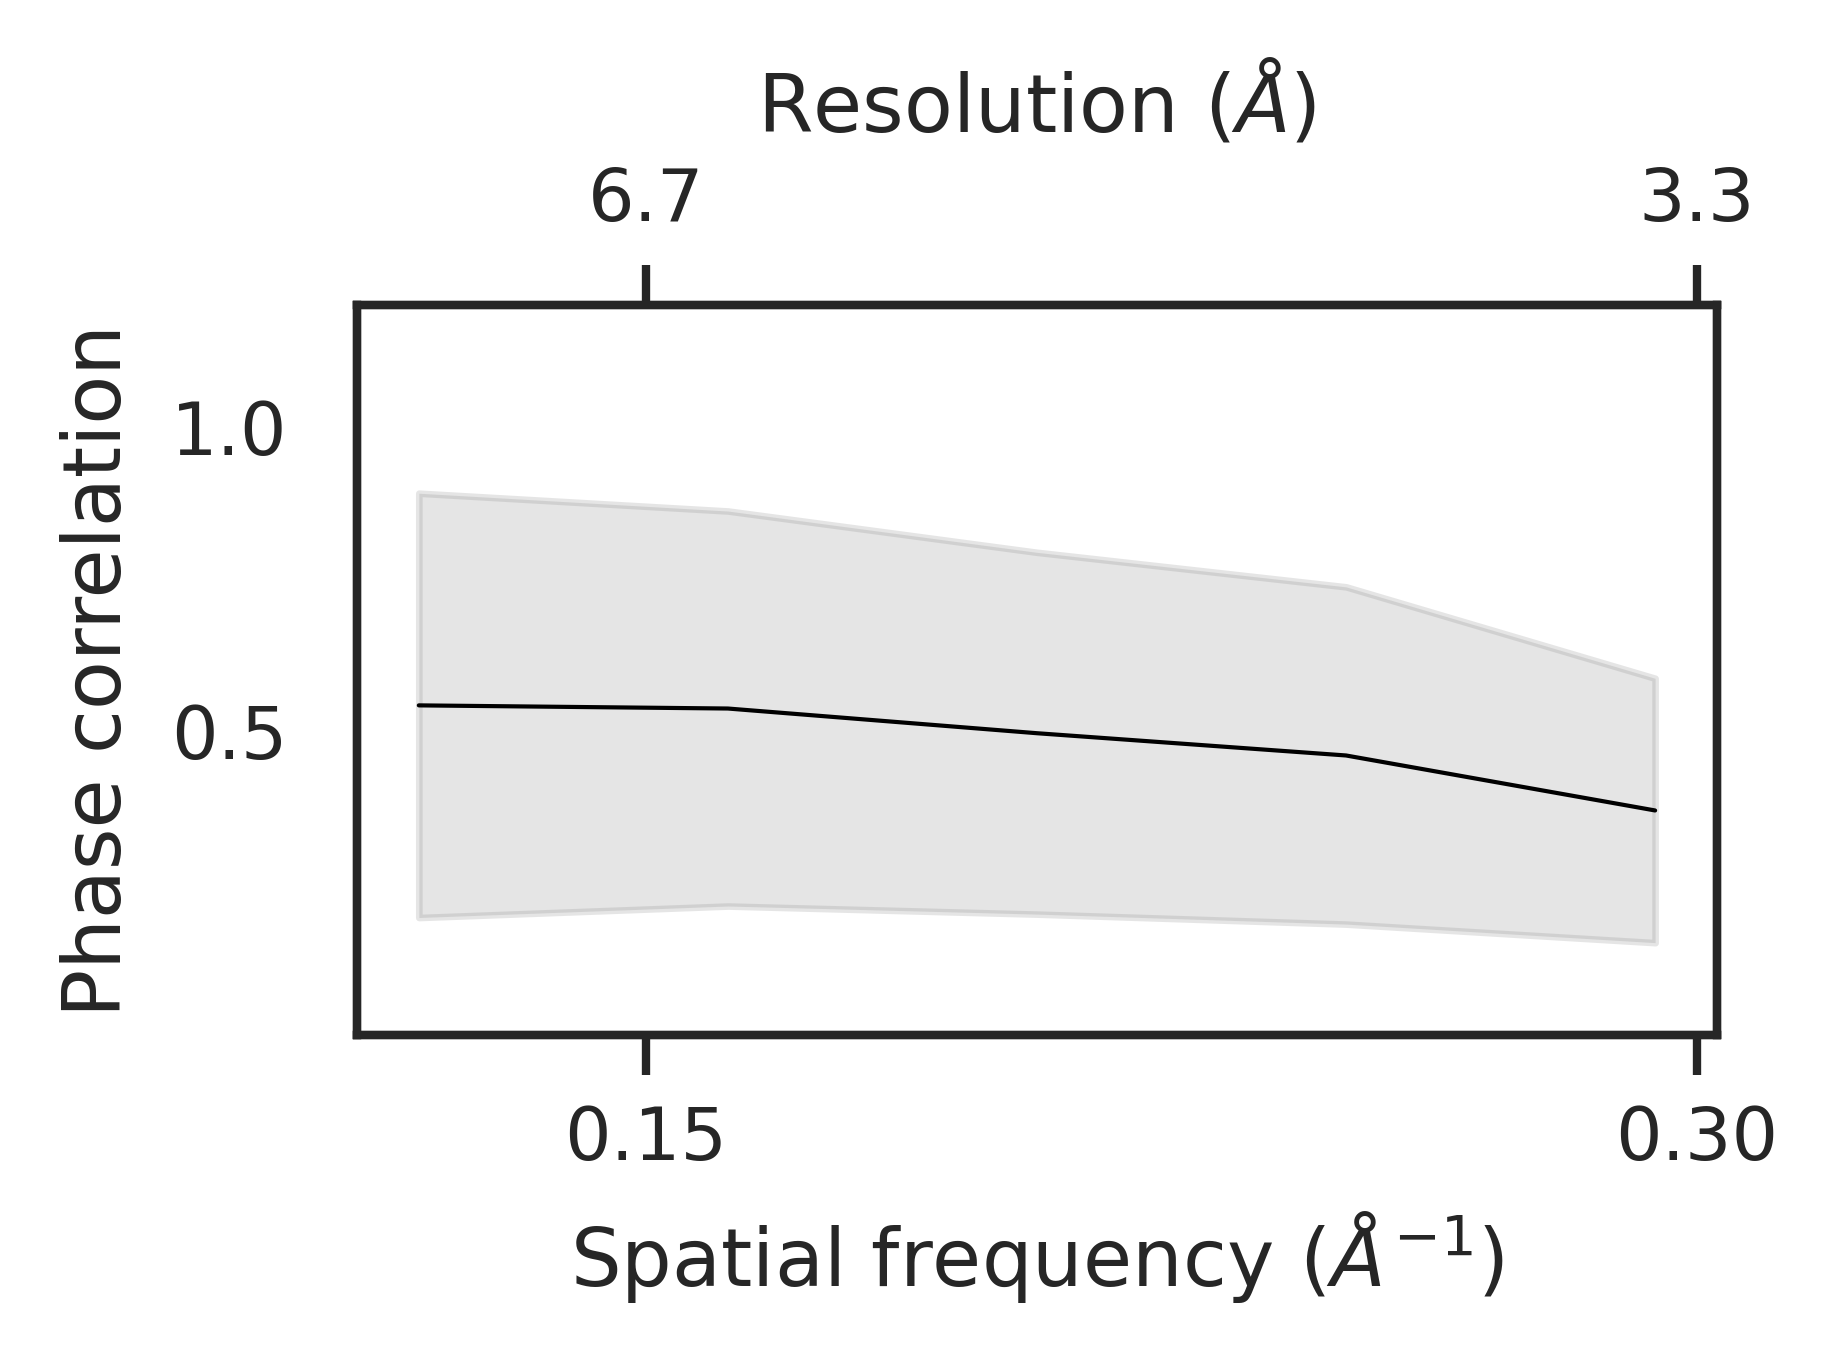

In [10]:
freq_local_20 = frequency_array(phase_correlations_20[0], apix)
xticks_20 = [0.15, 0.3]
fig_local_20 = pretty_plot_series(freq_local_20, phase_correlations_20, figsize_cm=(8,6), fontsize=10,linewidth=0.5, \
                                font="Helvetica",fontscale=1, alpha=0.2, xticks=xticks_20, num_xticks=5, yticks=yticks, ylims=ylims, xlims=None, labelsize=None, title=None)

fig_local_20_path = os.path.join(output_folder, "phase_correlation_local_20.pdf")
fig_local_20.savefig(fig_local_20_path, bbox_inches='tight')
